In [1]:
import os
import time
import torch

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

from models import ShallowNN
from utils import load_file
from evals import evaluate,evaluate_mae_with_confidence,influence
from evals import euclidean_distance, manhattan_distance, pairwise_euclidean_distance, accumulated_proximity, full_accumulated_proximity

features = 197
batch_size = 64
loss_fn = torch.nn.L1Loss()

In [2]:
client_ids = ["0_0","0_1","0_2","0_3","0_4","0_5","1_0","1_1","1_2","1_3","1_4","1_5","2_0","2_1","2_2","2_3","2_4","2_5","3_0","3_1","3_2","3_3","3_4","3_5"]

In [3]:
global_model = ShallowNN(features)
global_model.load_state_dict(torch.load('checkpt/epoch_500/_fedl_global_500.pth'))

<All keys matched successfully>

## Error Bars for Federated Learning vs Isolated Training

In [4]:
eval_list = []
for client in client_ids:
    val_data_path =  "testpt/"+str(client)+".pt"
    val_set = torch.load(val_data_path)
    val_loader = DataLoader(val_set, batch_size, shuffle = True)
    
    isolated_model_path = "checkpt/epoch_500/isolated/batch64_client_"+str(client)+".pth"
    isolated_model =  ShallowNN(features)
    isolated_model.load_state_dict(torch.load(isolated_model_path))
    
    isolated_mae,(iso_lower_band, iso_upper_band), _  = evaluate_mae_with_confidence(isolated_model, val_loader)
    federated_mae,(fed_lower_band, fed_upper_band), _ = evaluate_mae_with_confidence(global_model,val_loader)
    
    eval_dict = {"client_id":client, "Isolated Average MAE": round(isolated_mae, 4),
                 "Isolated MAE lower band":round(iso_lower_band,4),
                 "Isolated MAE upper band":round(iso_upper_band,4),
                 "Federated Average MAE" :round(federated_mae, 4),
                "Federated MAE lower band": round(fed_lower_band, 4),
                "Federated MAE upper band":round(fed_upper_band,4)}
    eval_list.append(eval_dict)
    #print(client,eval_dict)
eval_df = pd.DataFrame.from_dict(eval_list)
eval_df["clients"] = [i for i in range(1,25)] 

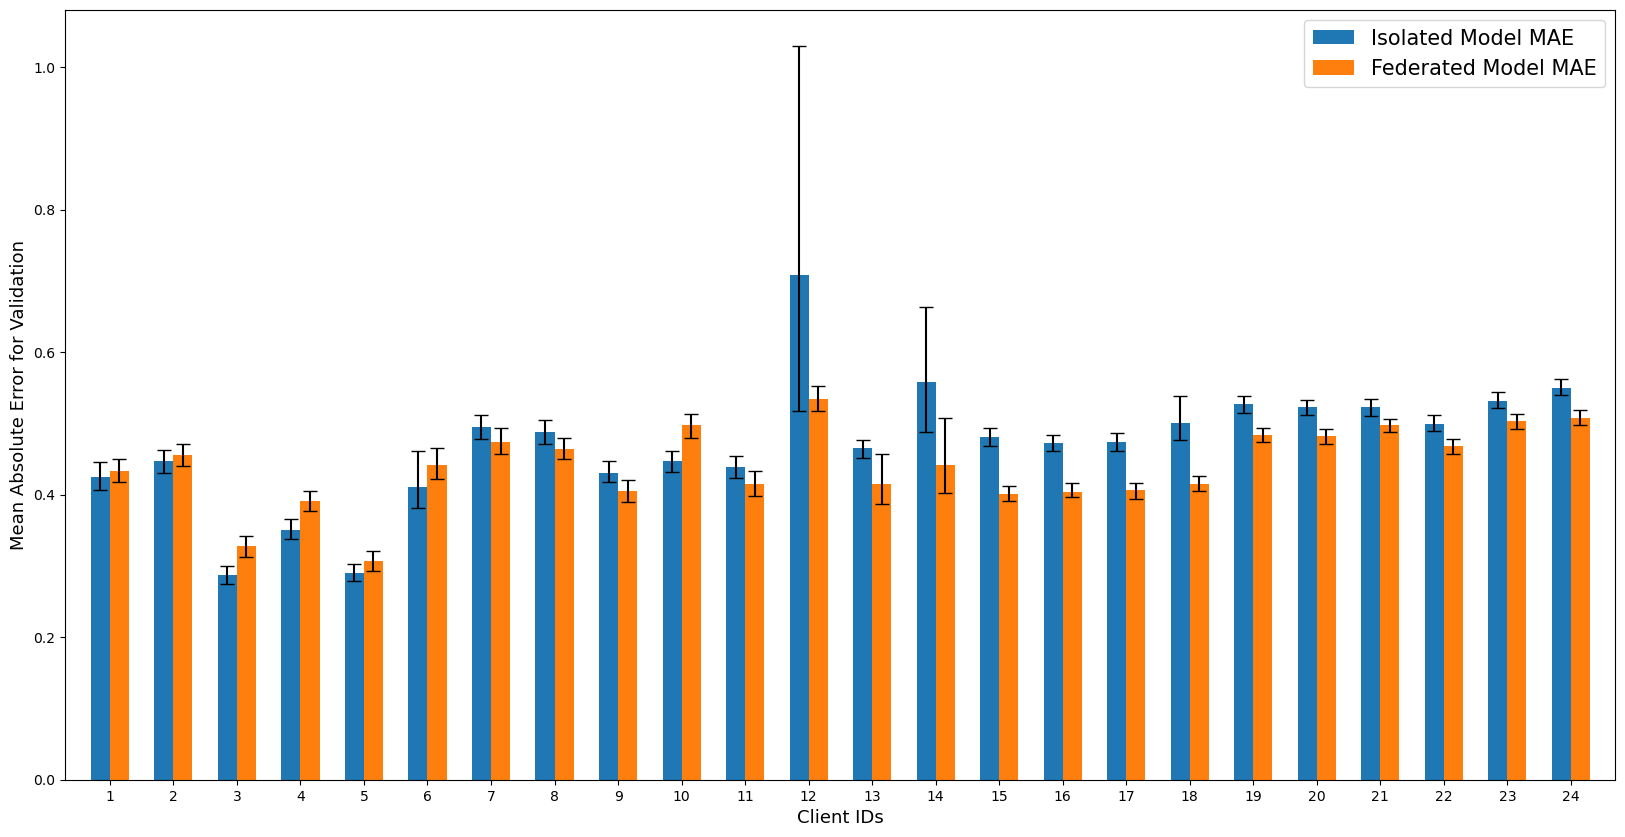

In [5]:
fig, ax = plt.subplots(figsize=(20, 10))
bar_width = 0.3  # Decrease the bar width
index = eval_df.index

bar1 = ax.bar(index - bar_width / 2, eval_df['Isolated Average MAE'], bar_width, yerr=[
    (eval_df["Isolated Average MAE"] - eval_df["Isolated MAE lower band"]),
    (eval_df['Isolated MAE upper band'] - eval_df["Isolated Average MAE"])
], capsize=5, label='Isolated Model MAE')

bar2 = ax.bar(index + bar_width / 2, eval_df['Federated Average MAE'], bar_width, yerr=[
    (eval_df["Federated Average MAE"] - eval_df["Federated MAE lower band"]),
    (eval_df['Federated MAE upper band'] - eval_df["Federated Average MAE"])
], capsize=5, label='Federated Model MAE')

ax.set_xlabel('Client IDs', fontdict={'fontsize': 13})
ax.set_ylabel("Mean Absolute Error for Validation", fontdict={'fontsize': 13})
ax.set_xticks(index)
ax.set_xticklabels(eval_df['clients'])
ax.legend(fontsize=15, loc="upper right")

# Adjust the xlim to decrease space at the left and right edges
ax.set_xlim(index[0] - 0.7, index[-1] + 0.7)

plt.show()

## Influence 

In [22]:
inf_val = []
for client in client_ids:
    model = ShallowNN(features)
    model.load_state_dict(torch.load('checkpt/epoch_500/influence/' + str(client)+ '_fedl_global_500.pth'))
    val_data_path =  "testpt/"+str(client)+".pt"
    val_set = torch.load(val_data_path)
    inf = influence(global_model,model,val_set)
    
    inf_val.append(round(inf.item(),4))
    #df.to_csv("influence2_"+str(client) + ".csv", index=False)
data = {"client id": client_ids, "inf_val": inf_val}
data = pd.DataFrame(data)
data.to_csv("insights/influence_with_pred_diff.csv" , index=False)

In [23]:
inf_val

[0.1851,
 0.2367,
 0.198,
 0.1953,
 0.2064,
 0.1626,
 0.2219,
 0.221,
 0.2149,
 0.1637,
 0.2106,
 0.1647,
 0.1411,
 0.1601,
 0.1214,
 0.1497,
 0.1297,
 0.125,
 0.1197,
 0.125,
 0.1227,
 0.1455,
 0.1268,
 0.1239]

In [7]:
global_model = ShallowNN(features)
global_model.load_state_dict(torch.load('checkpt/epoch_25/1_rounds_25_epochs_per_round/_fedl_global_1_25.pth'))

inf_val_test = []
for client in client_ids:
    model = ShallowNN(features)
    model.load_state_dict(torch.load('checkpt/epoch_25/influence/1_rounds_25_epochs_per_round/' + str(client)+ '_fedl_global_1_25.pth'))
    val_data_path =  "testpt/"+str(client)+".pt"
    val_set = torch.load(val_data_path)
    inf = influence(global_model,model,val_set)
    
    inf_val_test.append(round(inf.item(),4))
    #df.to_csv("influence2_"+str(client) + ".csv", index=False)
data_test = {"client id": client_ids, "inf_val": inf_val_test}
data_test = pd.DataFrame(data_test)
data_test.to_csv("insights/influence_with_pred_diff_test.csv" , index=False)

In [20]:
performance_inf = []
for client in client_ids:
    isolated_model = ShallowNN(features)
    isolated_model.load_state_dict(torch.load('checkpt/epoch_500/influence/' + str(client)+ '_fedl_global_500.pth'))
    val_data_path =  "testpt/"+str(client)+".pt"
    val_set = torch.load(val_data_path)
    val_loader = DataLoader(val_set, batch_size, shuffle = True)
    
    _, _ , isolated_mae = evaluate(isolated_model, val_loader, loss_fn)
    _, _ , global_mae = evaluate(global_model,val_loader,loss_fn)
    
    inf = global_mae - isolated_mae
    
    performance_inf.append(round(inf.item(),4))

data = {"client id": client_ids, "inf_val": performance_inf}
data = pd.DataFrame(data)
data.to_csv("insights/influence_with_mae.csv" , index=False)

In [21]:
data

,client id,inf_val
0,0_0,-0.0172
1,0_1,-0.0286
2,0_2,0.0482
3,0_3,0.0646
4,0_4,0.0485
5,0_5,0.0314
6,1_0,-0.0169
7,1_1,0.0088
8,1_2,0.0611
9,1_3,0.0599


## Eccentricities Method 1

$
\begin{equation}\label{eq:Ecc1}
\xi_i = \frac{2\sum_{j=1}^{k}d(\mathcal{H}_{\mu_i}, \mathcal{H}_{\mu_j})}{\sum_{l=1}^{k}\sum _{j=1}^{k} d(\mathcal{H}_{\mu_l}, \mathcal{H}_{\mu_j})},
\end{equation}
$

Where $\mathcal{H}_{\mu_i}$ is the Hessian matrix of client $i$, and $d(.,.)$ is the Euclidean distance between the Hessian matrices of two clients. 

In [ ]:
full_acc_proximity = full_accumulated_proximity(client_ids,euclidean_distance)

In [ ]:
matrix_dict = {
        key: torch.load("hessians/iso/" + str(key) + ".pth")
        for key in client_ids
    }

In [ ]:
eccentricities = []

for client in client_ids:
    client_matrix = torch.load("hessians/iso/" + str(client) + ".pth")
    acc_proximity = 0.0
    for key in matrix_dict:
        distance = accumulated_proximity(matrix_dict[key],client_matrix,euclidean_distance)
        acc_proximity += distance
    eccentricity = acc_proximity/full_acc_proximity
    eccentricities.append(round(eccentricity.item(),4))
    print(client,acc_proximity, acc_proximity/full_acc_proximity)
    
ecc_hessian = {"client id": client_ids, "hess_ecc": eccentricities}
ecc_hessian = pd.DataFrame(ecc_hessian)
ecc_hessian.to_csv("insights/eccentricity_with_hessian_euclidean.csv" , index=False)

In [ ]:
sum(eccentricities)

In [ ]:
full_acc_proximity_p = full_accumulated_proximity(client_ids,pairwise_euclidean_distance)

In [ ]:
for client in client_ids:
    client_matrix = torch.load("hessians/iso/" + str(client) + ".pth")
    acc_proximity = 0.0
    for key in matrix_dict:
        distance = accumulated_proximity(matrix_dict[key],client_matrix,pairwise_euclidean_distance)
        acc_proximity += distance
    
    print(client,acc_proximity, 2*acc_proximity/full_acc_proximity_p)

## Global Model Based Eccentricity Method 1

$
\begin{equation}\label{eq:Ecc2}
\xi_i = \frac{d(\mathcal{H}^i_{{\mathcal M}}, \mathcal{H}_{\mu_i})}{\sum _{j=1}^{k} d(\mathcal{H}^j_{{\mathcal M}}, \mathcal{H}_{\mu_j})},
\end{equation}
$

Where $\mathcal{H}_{\mu_i}$ and $\mathcal{H}_{\mu_j}$ are respectively, the Hessian matrices of local models $\mu_i$ and $\mu_j$, for $j=1, 2,\ldots, k$, and $\mathcal{H}^i_{{\mathcal M}}$ and $\mathcal{H}^j_{{\mathcal M}}$ are the Hessian matrices of global model $\mathcal M$ calculated respectively on the validation sets of clients $i$ and $j$, for $j=1, 2,\ldots, k$,  and $d(.,.)$ is the Euclidean distance between two Hessian matrices. 


In [ ]:
glo_matrix_dict = {
        key: {"iso" : torch.load("hessians/iso/" + str(key) + ".pth"),
             "fed" : torch.load("hessians/fed/" + str(key) + ".pth")}
        for key in client_ids
    }

In [ ]:
distances = []
for client in client_ids:
    distance = accumulated_proximity(glo_matrix_dict[client]["iso"],glo_matrix_dict[client]["fed"], euclidean_distance)
    distances.append(distance)
    #print(client,acc_proximity, 2*acc_proximity/full_acc_proximity_p)

In [ ]:
full_acc = sum(distances)

In [ ]:
ecc_dis = []
for i in distances:
    ecc_dis.append(round((i/full_acc).item(),4))
ecc_diss = {"client id": client_ids, "hess_dis": ecc_dis}
ecc_diss = pd.DataFrame(ecc_diss)
ecc_diss.to_csv("insights/eccentricity_global_model_based_1.csv" , index=False)

## Global Model Based Eccentricity Method 2

$
\begin{equation}\label{eq:Ecc3}
\xi_i = \frac{2\sum_{j=1}^{k}d((\mathcal{H}^i_{\mathcal {M}} - \mathcal{H}_{\mu_i}), (\mathcal{H}^j_{\mathcal {M}} - \mathcal{H}_{\mu_j}))}{\sum_{l=1}^{k}\sum _{j=1}^{k} d((\mathcal{H}^l_{{\mathcal M}} - \mathcal{H}_{\mu_l}), (\mathcal{H}^j_{{\mathcal M}} - \mathcal{H}_{\mu_j}))},
\end{equation}
$

Where $\mathcal{H}_{\mu_i}$, $\mathcal{H}_{\mu_l}$ and $\mathcal{H}_{\mu_j}$ are respectively, the Hessian matrices of local models $\mu_i$, $\mu_l$ and $\mu_j$, for $l, j=1, 2,\ldots, k$, and $\mathcal{H}^i_{{\mathcal M}}$, $\mathcal{H}^l_{{\mathcal M}}$ and $\mathcal{H}^j_{{\mathcal M}}$ are the Hessian matrices of global model $\mathcal M$ calculated respectively on the validation sets of clients $i$, $l$ and $j$, for $l, j=1, 2,\ldots, k$,  and $d(.,.)$ is the Euclidean distance between the two matrices obtained by subtracting the corresponding Hessian matrices. 




In [ ]:
full_matrix_dict = {
        key: {"iso" : torch.load("hessians/iso/" + str(key) + ".pth"),
             "fed" : torch.load("hessians/fed/" + str(key) + ".pth")}
        for key in client_ids
    }
diff_matrix_dict = {key : full_matrix_dict[key]["fed"] - full_matrix_dict[key]["iso"]
                        for key in full_matrix_dict}

In [ ]:
proximities = []
for i in client_ids:
    distances = []
    for j in client_ids:
        distance = accumulated_proximity(diff_matrix_dict[i],diff_matrix_dict[j],manhattan_distance)
        distances.append(distance)
    print(round(sum(distances).item(),4))
    proximities.append(sum(distances).item())

In [ ]:
full_proximity = sum(proximities)
full_proximity

In [ ]:
full_proximity = sum(proximities)

ecc = []
for i in proximities:
    ecc.append(round((2 * i/full_proximity),4))
    
eccentricities_3 = {"client id": client_ids, "eccentricity": ecc}
eccentricities_3 = pd.DataFrame(eccentricities_3)
eccentricities_3.to_csv("insights/eccentricities_global_model_based_2.csv" , index=False)

## Global Model Based Eccentricity Method 3

$
\begin{equation}\label{eq:Ecc1}
\xi_i = \frac{2\sum_{j=1}^{k}d(\mathcal{H}^i_{\mathcal M}, \mathcal{H}^j_{\mathcal M})}{\sum_{l=1}^{k}\sum _{j=1}^{k} d(\mathcal{H}^l_{\mathcal M}, \mathcal{H}^j_{\mathcal M})},
\end{equation}
$

where $\mathcal{H}^i_{\mathcal M}$ is the Hessian matrix of client $i$, and $d(.,.)$ is the Euclidean distance between the Hessian matrices global with respect to the validation dataset of clients $i$. 

In [ ]:
matrix_dict_fed = {
        key: torch.load("hessians/fed/" + str(key) + ".pth")
        for key in client_ids
    }

In [ ]:
eccentricities = []

for client in client_ids:
    client_matrix = torch.load("hessians/fed/" + str(client) + ".pth")
    acc_proximity = 0.0
    for key in matrix_dict_fed:
        distance = accumulated_proximity(matrix_dict_fed[key], client_matrix, euclidean_distance)
        acc_proximity += distance
    
    eccentricities.append(round(acc_proximity.item(),4))
    print(round(acc_proximity.item(),4))

In [ ]:
full_ecc = []
full_acc_proximity = sum(eccentricities)

for item in eccentricities:
    full_ecc.append((item/full_acc_proximity))

In [ ]:
ecc_hessian = {"client id": client_ids, "hess_ecc": full_ecc}
ecc_hessian = pd.DataFrame(ecc_hessian)
ecc_hessian.to_csv("insights/eccentricity_with_global_model_based_3.csv" , index=False)

## Eccentricity Frobenius Method 3



In [ ]:
matrix_dict = {
        key: torch.load("hessians/iso/" + str(key) + ".pth")
        for key in client_ids
    }

In [ ]:
eccentricities = []

for client in client_ids:
    client_matrix = torch.load("hessians/iso/" + str(client) + ".pth")
    acc_norm = 0.0
    for key in matrix_dict:
        norm = torch.norm(client_matrix - matrix_dict[key] , 'fro')
        acc_norm += norm
    
    eccentricities.append(round(acc_norm.item(),4))
    print(round(acc_norm.item(),4))

In [ ]:
full_ecc = []
full_acc_proximity = sum(eccentricities)*2

for item in eccentricities:
    full_ecc.append(2*(item/full_acc_proximity))

In [ ]:
ecc_hessian = {"client id": client_ids, "hess_ecc": full_ecc}
ecc_hessian = pd.DataFrame(ecc_hessian)
ecc_hessian.to_csv("insights/eccentricity_with_forb_norm.csv" , index=False)

In [ ]:
import numpy as np

def calculate_quantiles(data, quantiles):
    """
    Calculate quantiles of a list of values.

    Args:
    data (list or numpy array): The list of values.
    quantiles (list of float): A list of quantile values to calculate (e.g., [0.25, 0.5, 0.75] for quartiles).

    Returns:
    list of float: The quantile values requested.
    """
    # Ensure the data is in numpy array format
    data = np.array(data)

    # Calculate quantiles using numpy's percentile function
    quantile_values = np.percentile(data, [q * 100 for q in quantiles])

    return quantile_values

# Example usage:

data = [ 0.1055 ,0.1187 , 0.089, 0.1447 ,0.0954 ,0.1218 ,0.1179,0.1098,0.0913,0.1503,0.0928,0.1243,0.0799,0.1592,0.0829,0.1253,0.0821,0.0851,0.1029,0.1059,0.0983,0.1236,0.0837,0.0869]
quantiles = [0.25, 0.5, 0.75]
result = calculate_quantiles(data, quantiles)
print("Quantiles:", result)
